# sketch2frog: Generating Frogs from Simple Sketches

In [233]:
from IPython import get_ipython
get_ipython().run_line_magic('reload_ext', 'autoreload')
get_ipython().run_line_magic('autoreload', '2')
get_ipython().run_line_magic('matplotlib', 'inline')

In [204]:
import matplotlib.pyplot as plt
from IPython.display import Video
import wandb
from src.config import PATH

SIZE = 4
RUN_NAME = "2021-10-13 1327"
WANDB_RUN = "run-20211013_132756-3qtwh0mv"
WANDB_DIR = PATH.parent / 'notebooks' / 'wandb' / WANDB_RUN

api = wandb.Api()
run = api.run("/yleneb/sketch2frog/runs/3qtwh0mv")

In this notebook I describe the process of creating sketch2frog, a pix2pix model inspired by [edges2cats](https://affinelayer.com/pixsrv/index.html) which maps black and white sketches of frogs to colour images. 

## The Dataset

I found a [dataset of over 7000 frogs on a white background](https://github.com/jonshamir/frog-dataset), using these I generated black and white sketch-like images to create a dataset of sketch-image pairs. I could then train a model to map from my generated sketches to the target colour images.

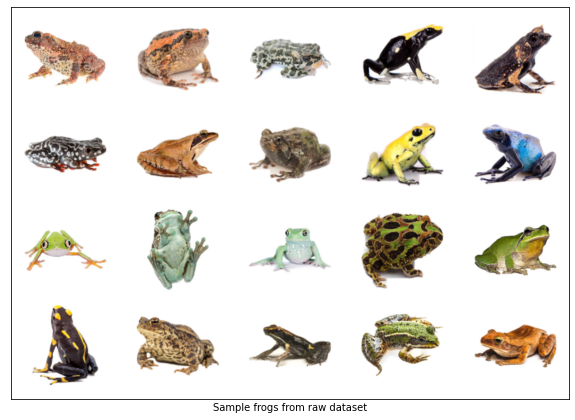

In [59]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax.imshow(plt.imread("figures/raw-frogs.png"), cmap='gray')
ax.set_xlabel('Sample frogs from raw dataset')
ax.set(xticks=[], yticks=[])
fig.patch.set_facecolor('white')
plt.show()
plt.close()

To create sketches from these images I used a pretrained edge detection model, [DexiNed (Dense Extreme Inception Network)](https://github.com/xavysp/DexiNed/tree/master/DexiNed-TF2). DexiNed is a state-of-the-art, CNN based edge detector inspired by the Xception network and HED (Holistically-Nested Edge Detection).

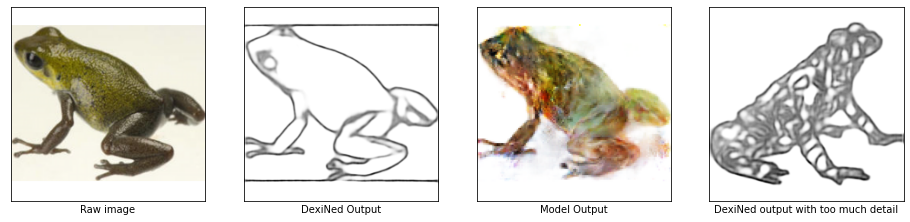

In [168]:
fpaths = ['figures/frog-8/raw.png','figures/frog-8/dexined.png','figures/frog-8/background-problems.png','figures/frog-439/dexined.png']
captions = ['Raw image','DexiNed Output', 'Model Output','DexiNed output with too much detail']

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(SIZE*len(captions),SIZE))
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

DexiNed does a good job of transforming an input frog to a sketch-like image, however it has some problems. DexiNed detects a lot of internal detail resulting in a sketch which is far more complex than a human would draw, it also draws the outlines of shadows and edges of off-white backgrounds. 

While most frogs sit on a white background, many do not or have a large shadow. This proved to be an issue with earlier models which try to replicate background colour.

To remove these backgrounds and simplify the sketches I used a U2Net model pretrained for background removal [in this colab](https://colab.research.google.com/github/shreyas-bk/U-2-Net-Demo/blob/master/DEMOS/U_2_Netp_Demonstration_Colab.ipynb#scrollTo=eWxv7eDJiq5b) from [shreyas-bk](https://github.com/shreyas-bk/U-2-Net). In particular this model is U2Netp, a smaller model with 4.7Mb weights, as opposed to the full U2Net with 176.3Mb weights.

U2Net outputs a mask which I applied to the raw image to remove background. I then applied DexiNed to the U2Net masks to get sketches with no internal detail.

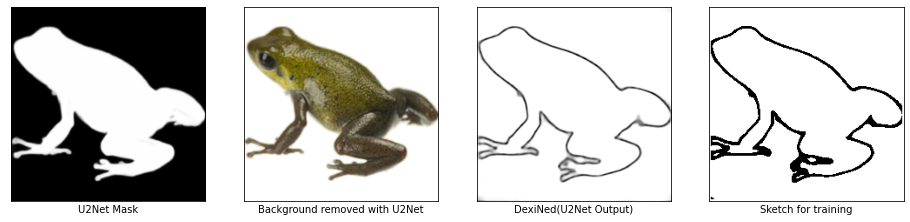

In [72]:
fpaths = ['figures/frog-8/unet.png','figures/frog-8/unet masked.png','figures/frog-8/dexined(u2net output).png','figures/frog-8/outline-sketch.png']
captions = ['U2Net Mask','Background removed with U2Net','DexiNed(U2Net Output)','Sketch for training']
SIZE = 4

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(SIZE*len(captions),SIZE))
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

These new sketches were far more similar to a hand drawn sketch and while they did occasionally amputate frog limbs, generated frogs no longer had background problems. However, with no internal detail to learn from, models trained with this dataset struggled placing eyes and mouths, omitting them entirely or sometimes placing too many. While some generated frogs are convincing, many are just blobs of frog flesh.

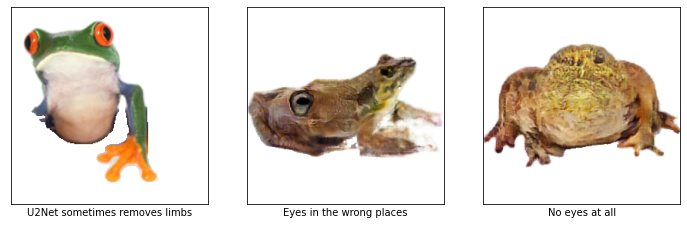

In [169]:
fpaths = ['figures/lost legs.png','figures/eyes-in-wrong-places.png','figures/frog-with-no-eyes.png']
captions = ['U2Net sometimes removes limbs','Eyes in the wrong places','No eyes at all']

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(SIZE*len(captions),SIZE))
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

As a compromise I created a final set of sketches by applying DexiNed to the masked target images, resulting in sketches with no backgrounds but lots of internal detail.

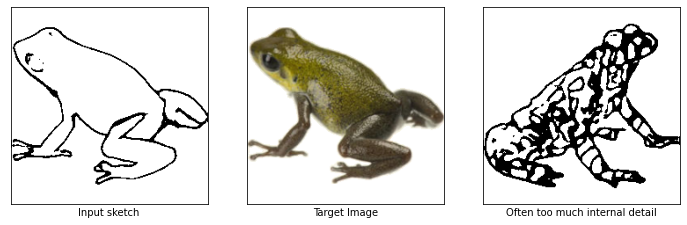

In [77]:
fpaths = ['figures/frog-8/sketch.png','figures/frog-8/unet masked.png','figures/frog-439/sketch.png']
captions = ['Input sketch','Target Image','Often too much internal detail']

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(SIZE*len(captions),SIZE))
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

## pix2pix: Paired Image-to-Image Translation

[Pix2pix](https://phillipi.github.io/pix2pix/) is a Conditional GAN which takes an image as input and learns to generate a transformation of that image. It consists of a UNet generator and a PatchGAN discriminator and is trained via the standard GAN training loop:

1. Generate a batch from the generator and a batch of real samples
2. Train just the discriminator
3. Freeze the discriminator and train just the generator using the generated images
4. Repeat

Pix2pix is ideal for this problem as we have a paired dataset of sketches and images. Alternatively, we could have created an unpaired dataset - a set of frogs and a set of sketches of anything - then used an unpaired image-to-image translation model such as [CycleGAN](https://junyanz.github.io/CycleGAN/). I chose pix2pix for this project as it is much smaller so should allow for faster training and iteration on my home computer.

### UNet Generator

UNet is a fully convolutional network (FCN) with a similar architecture to an autoencoder. The input image is encoded through convolutional layers with stride 2, then decoded back to full size with transposed convolutions. There are skip connections between the output of the encoder at each layer and the equivalent layer in the decoder.

[![pix2pix generator](architecture_plots/pix2pix_gen.jpg "pix2pix Generator Architecture")](https://github.com/yleneb/sketch2frog/blob/master/sketch2frog/reports/architecture_plots/pix2pix_gen.pdf)

ReLUs in the encoder are all leaky with alpha 0.2. All convolutional and transposed convolutional layers have stride 2, and the number of filters is written below them. On the decoder side, the encoded image is sent through a transpose convolution layer which upscales the image, then batch normalisation and dropout are applied. This volume is then concatenated with the output of the matching layer in the encoder before a final ReLU activation is applied and the process repeats. Dropout is only applied in the first three layers of the decoder, and batch normalisation is not applied to the bottleneck or the first convolutional layer.

Traditional GANs take a vector of Gaussian noise as input so that generated images are not all the same. Pix2pix takes an image as input so randomness needs to come from elsewhere, in this case there is 50% dropout in the first 3 layers of the decoder which is used both during training and for inference.

I also built a smaller model with fewer layers to allow for faster iteration during development - runs with this model took about 1 hour using 128x128 input images.

### PatchGAN Discriminator

The output of the UNet generator is concatenated with its input, the resulting tensor is then sent into the PatchGAN discriminator. Despite the name PatchGAN isn't a GAN, it is a fully convolutional network which learns to classify "patches" of the generated image as real or fake. Following the recommendation of the original pix2pix paper, I used a 70x70 PatchGAN, each cell of the output tensor classifies a 70x70 patch of the input image as real or fake - a good generator should produce images that are convincing everywhere, not just overall. This is an improvement over a simple binary classifier as it gives more detailed feedback to the generator.

[![pix2pix discriminator](architecture_plots/pix2pix_disc.jpg "pix2pix Discriminator Architecture")](https://github.com/yleneb/sketch2frog/blob/master/sketch2frog/reports/architecture_plots/pix2pix_disc.pdf)

#### Loss Functions

$$
\begin{align}
\underset{D}{\min} \; L(D) &=
\dfrac{1}{2} \mathbb{E} \left [ (D(\mathbf{x}) - 1)^2 \right ] + 
\dfrac{1}{2} \mathbb{E} \left [ (D(G(\mathbf{z})) - 0)^2 \right ] \\[1em]
\underset{G}{\min} \; L(G) &=
\mathbb{E} \left [ (D(G(\mathbf{z})) - 1)^2 \right ] + 
\lambda \times \mathbb{E} \left [ \; \left | G(\mathbf{z}) - y \right | \; \right ]
\end{align}
$$

The discriminator's goal is to minimize the mean squared distance between the prediction and ground truth for each patch, in the process learning to correctly classify real and fake images.

The generator uses a composite of adversarial (MSE) loss and L1 (pixel distance) loss. The adversarial loss encourages the generator to output images which are plausable in the target domain. The pixel distance loss act as a regulariser to ensure the output is a credible translation of the input image. The total generator loss is weighted through the hyperparameter $\lambda$ which is set to 100.

The original pix2pix paper uses Binary Cross Entropy loss, but I found MSE performed much better on this dataset.

I also used one-sided label smoothing as regularisation to slow down training in the discriminator. While training the discriminator only, real images are given a label sampled uniformly from [0.95, 1.0] instead of being set to 1.

## Results

I trained the full size model on 256x256 images for 150 epochs, which took 10 hours on an Nvidia 2070 Super GPU with 8gb VRAM and 64gb system memory.

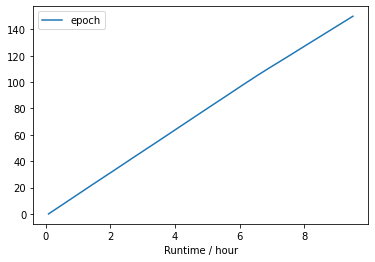

In [171]:
fig = (run
 .history()
 [['epoch', '_runtime']]
 .dropna()
 .set_index('epoch')
 .loc[:150] # only want first 150 epochs
 .apply(lambda x: x/60/60)
 .reset_index()
 .rename(columns={'_runtime':'Runtime / hour'})
 .set_index('Runtime / hour')
 .plot())
plt.show()
plt.close()

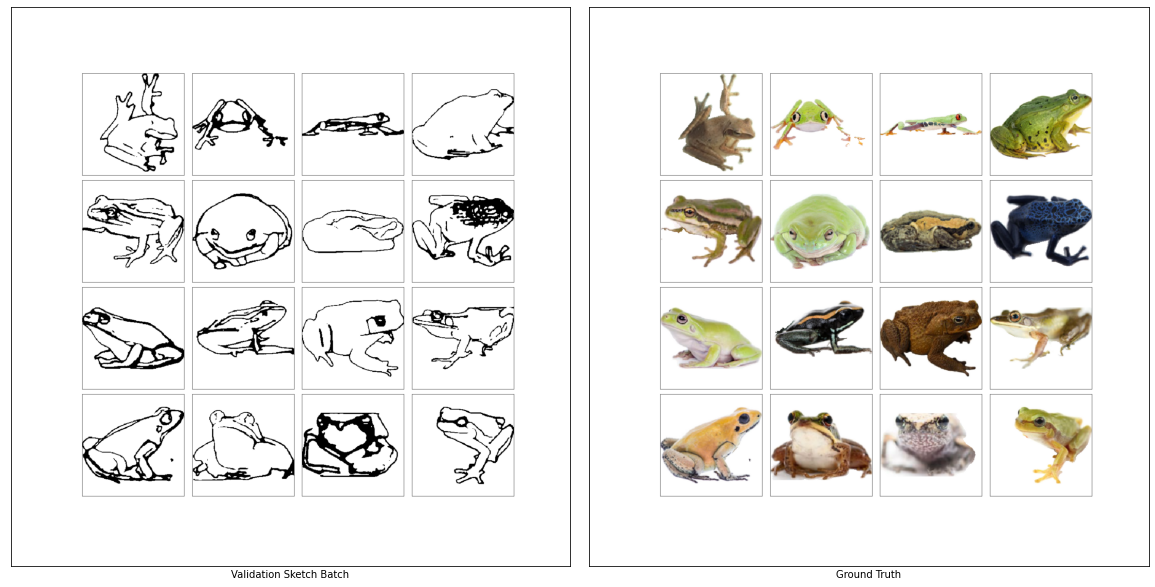

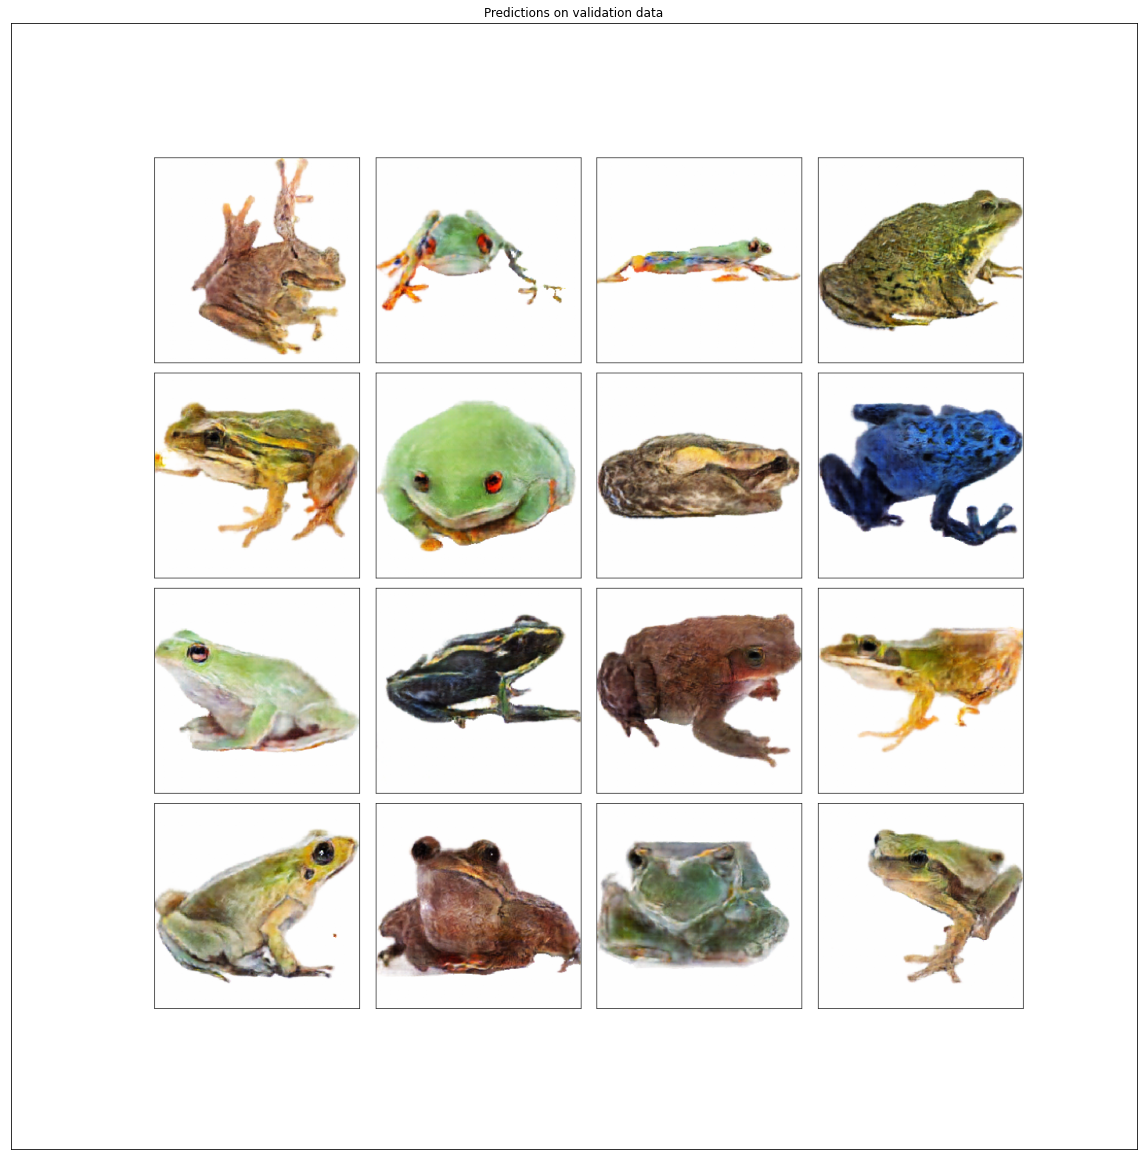

In [201]:
fpaths = ['figures/Sample Sketch Batch.png','figures/Sample Target Batch.png',]
captions = ['Validation Sketch Batch', 'Ground Truth']

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(2*SIZE*len(captions),2*SIZE), constrained_layout=True)
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

# plot 2
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4*SIZE,4*SIZE), constrained_layout=True)
ax.imshow(plt.imread('figures/Sample Pred Batch.png'), cmap='gray')
ax.set_title('Predictions on validation data')
ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

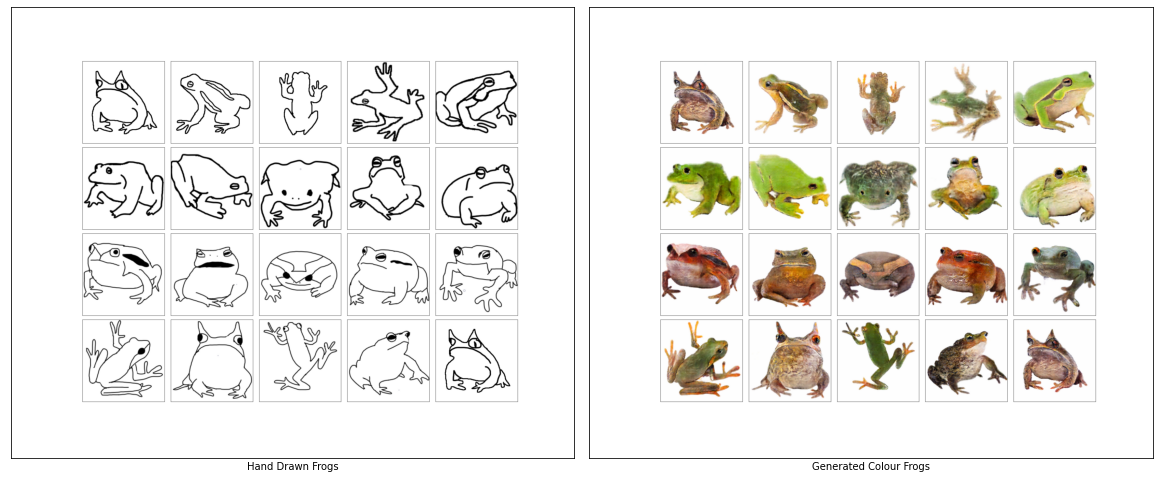

In [195]:
fpaths = ['figures/hand_drawn_input.png','figures/hand_preds_0.png',]
captions = ['Hand Drawn Frogs', 'Generated Colour Frogs']

fig, axs = plt.subplots(nrows=1, ncols=len(captions), figsize=(2*SIZE*len(captions),2*SIZE), constrained_layout=True)
for ax, fpath, caption in zip(axs, fpaths, captions):
    ax.imshow(plt.imread(fpath), cmap='gray')
    ax.set_xlabel(caption)
    ax.set(xticks=[], yticks=[])
    
fig.patch.set_facecolor('white')
plt.show()
plt.close()

Despite my poor drawing skills, sketch2frog as successfully mapped my drawings to colour frogs. Some are much better than others, and in particular the texture of frog skin is unusual - perhaps more training or reducing the learning rate for these finer details would be beneficial.

When creating the training dataset I was concerned that the sketches were too detailed and not comparable to hand drawn frogs. However, given these results I suspect the detailed training set was beneficial, since the model has also learnt to translate stripes and markings onto the coloured frogs.

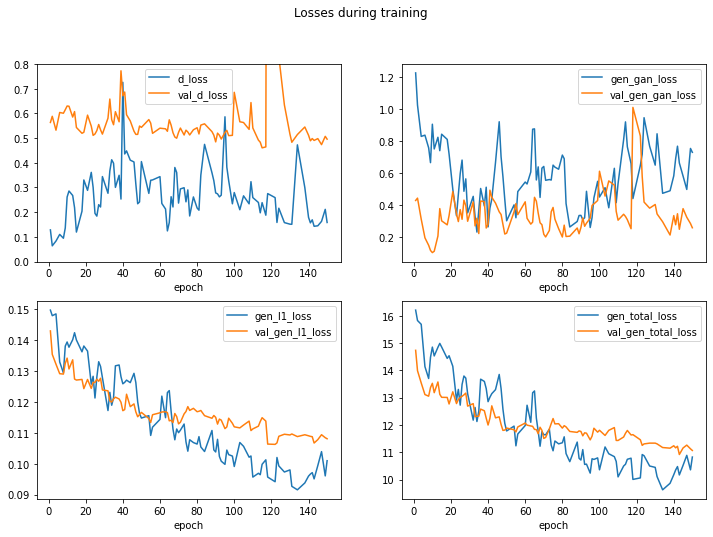

In [145]:
# get all the training logs
df = run.history()

# select useful columns
grouped = (
df[['epoch',
       'gen_l1_loss',    'val_gen_l1_loss',
      'gen_gan_loss',   'val_gen_gan_loss',
    'gen_total_loss', 'val_gen_total_loss',
            'd_loss',         'val_d_loss']]
 .dropna()
 .set_index('epoch')
 .loc[:150] # only want first 150 epochs
 .ewm(0.99) # apply smoothing
 .mean() # group together train and validation metrics
 .groupby(lambda x: x.replace('val_',''), axis=1)
)

# prepare fig
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,8))

# plot groups
for (key, ax) in zip(grouped.groups.keys(), axes.flatten()):
    (grouped
     .get_group(key)
     .plot(ax=ax)
     )

# adjust and show
axes[0,0].set_ylim(0,0.8)
ax.legend()
plt.suptitle('Losses during training')
plt.show()
plt.close()

Evaluating a GAN is more complicated than other models, since the models are in competition we should not expect the losses to fall to a minimum. However, there is still useful information in these loss curves.

The L1 loss reduces during training, this is to  be expected. As the generator improves its output ought to be more similar to the true frog image. The total generator loss decreases with L1, since $\lambda=100$. A perfect generator would have an L1 loss of 0 but would not necessarily have total loss near 0.

The discriminator loss describes the performance of the PatchGAN and remains fairly constant, it is not increasing or decreasing over time. This tells us that neither the generator nor discriminator is dominating; for example a loss near 0 would imply the discriminator has won and can almost always tell between a real and fake, we could then try increasing regularisation in the discriminator. The corresponding generator loss would be 1 since $D(G(\mathbf{z})=0$ everywhere and the adversarial loss is given by $\mathbb{E} \left [ (D(G(\mathbf{z})) - 1)^2 \right ]$. 

We can also note that the discriminator loss and generator adversarial loss are correlated. If the discriminator starts performing worse it will more often misclassify fake images, thus the generator will appear to perform better and its loss will decrease - NB. the spike in d_loss at epoch 80 with an associated drop in gen_gan_loss. It could also be useful to split the discriminator loss into separate metrics for real and fake images.

In general validation curves aren't particularly useful when training GANs, but they can still help with debugging. In an earlier run I noticed a large difference between training and validation losses, indicative of overfitting, and discovered that data augmentation wasn't being applied to the training set.

In [203]:
Video("figures/Training GIF.mp4", width=800)

## Further Work

To improve results I would start by refining the dataset, some of the generated sketches do not resemble frogs at all and should simply be removed. We could also try to synthetically increase the dataset size by generating multiple different sketches for each image, some with more detail than others. This would act as another form of data augmentation.

Beyond simply increasing the number of bottleneck lasyers or filters, we could try to swap out the UNet generator for a more modern [SPADE generator](https://github.com/NVlabs/SPADE). During training I chose a larger batch size for faster iteration, but the original pix2pix paper recommends using a batch size of 1. We could try training with batch size 1 or replacing the batch normalisation layers with instance normalisation.

## References

1. [Image-to-Image Translation with Conditional Adversarial Networks (pix2pix paper)](https://arxiv.org/abs/1611.07004)
2. [pix2pix: Image-to-image translation with a conditional GAN - TensorFlow Tutorials](https://www.tensorflow.org/tutorials/generative/pix2pix)
3. [How to Develop a Pix2Pix GAN for Image-to-Image Translation - Jason Brownlee](https://machinelearningmastery.com/how-to-develop-a-pix2pix-gan-for-image-to-image-translation/)
4. [Modern implementation of a GAN in Keras - François Chollet](https://twitter.com/fchollet/status/1250622989541838848?s=20)
5. [How to Train a GAN? Tips and tricks to make GANs work - Soumith Chintala](https://github.com/soumith/ganhacks)

## Try it out

[Try out the trained model here](https://colab.research.google.com/drive/1pl4wXsYgd79jVScqP5TdrBXsh7Me66ZE?usp=sharing)